In [2]:
import urllib.request
import urllib.error # Для обработки ошибок HTTP и URL
import zipfile
import os
import shutil # Для удаления директории, если нужно
import sys # Для sys.stdout.flush()
import time # Для задержки между попытками
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import cv2
import tifffile
import matplotlib.pyplot as plt


In [ ]:
dataset_url = "https://zenodo.org/records/8346860/files/01_Train_Val_Oil_Spill_images.7z?download=1"
output_filename = "01_Train_Val_Oil_Spill_images.7z" # Имя, под которым файл будет сохранен локально

# Директория для распакованных данных.
# Вы можете изменить это на любой путь на вашем компьютере, например, 'data/'
# или 'C:/Users/YourUser/Documents/MyDataset/'
unzip_directory = "C:\\Users\\Sirius\\Downloads"

# Параметры повторных попыток загрузки
max_retries = 5 # Максимальное количество попыток загрузки
retry_delay_seconds = 10 # Задержка между попытками в секундах

# --- Загрузка файла ---
print(f"Попытка загрузки датасета с: {dataset_url}")
print(f"Файл будет сохранен как: {output_filename}")

download_successful = False
for attempt in range(1, max_retries + 1):
    print(f"\nПопытка загрузки {attempt} из {max_retries}...")
    try:
        # Открываем URL для чтения
        with urllib.request.urlopen(dataset_url) as response:
            # Проверяем, что запрос был успешным (код 200)
            if response.getcode() != 200:
                raise urllib.error.HTTPError(dataset_url, response.getcode(),
                                             response.reason, response.headers, None)

            # Получаем общий размер файла, если он доступен
            total_size = int(response.headers.get('Content-Length', 0))
            downloaded_size = 0
            block_size = 8192 # Размер блока для чтения (8 КБ)

            # Открываем локальный файл для записи в бинарном режиме
            with open(output_filename, 'wb') as out_file:
                while True:
                    buffer = response.read(block_size)
                    if not buffer:
                        break # Если буфер пуст, значит, файл прочитан до конца
                    out_file.write(buffer)
                    downloaded_size += len(buffer)

                    # Выводим прогресс загрузки
                    if total_size > 0:
                        progress = (downloaded_size / total_size) * 100
                        # Используем \r для перезаписи строки и end='' для предотвращения новой строки
                        sys.stdout.write(f"\rЗагружено: {downloaded_size / (1024*1024):.2f} MB / {total_size / (1024*1024):.2f} MB ({progress:.2f}%)")
                        sys.stdout.flush() # Принудительно выводим буфер stdout
                    else:
                        # Если размер файла неизвестен, просто показываем загруженный объем
                        sys.stdout.write(f"\rЗагружено: {downloaded_size / (1024*1024):.2f} MB")
                        sys.stdout.flush()

        print(f"\nЗагрузка '{output_filename}' завершена.")
        download_successful = True
        break # Выходим из цикла повторных попыток, если загрузка успешна

    except urllib.error.HTTPError as e:
        print(f"\nОшибка HTTP при загрузке файла (код: {e.code}, причина: {e.reason}): {e}")
    except urllib.error.URLError as e:
        print(f"\nОшибка URL при загрузке файла (причина: {e.reason}): {e}")
    except Exception as e:
        print(f"\nПроизошла непредвиденная ошибка при загрузке файла: {e}")

    # Если загрузка не удалась, удаляем частично загруженный файл перед следующей попыткой
    if os.path.exists(output_filename):
        os.remove(output_filename)
        print(f"Удален частично загруженный файл '{output_filename}'.")
    if attempt < max_retries:
        print(f"Повторная попытка через {retry_delay_seconds} секунд...")
        time.sleep(retry_delay_seconds)
    else:
        print(f"Все {max_retries} попыток загрузки не удались. Выход.")
        sys.exit(1) # Выходим с кодом ошибки

if not download_successful:
    sys.exit(1) # Выходим, если загрузка не была успешной после всех попыток

# --- Проверка размера загруженного файла ---
if os.path.exists(output_filename):
    file_size_bytes = os.path.getsize(output_filename)
    print(f"Размер загруженного файла '{output_filename}': {file_size_bytes / (1024*1024*1024):.2f} GB")
else:
    print(f"Ошибка: Файл '{output_filename}' не был загружен.")
    sys.exit(1)

# --- Распаковка архива ---
# Сначала создадим директорию для распакованных данных, если ее нет.
os.makedirs(unzip_directory, exist_ok=True)

print(f"\nНачинаем распаковку '{output_filename}' в '{unzip_directory}' (это может занять много времени)...")

try:
    # Проверяем, является ли файл ZIP-архивом
    if zipfile.is_zipfile(output_filename):
        with zipfile.ZipFile(output_filename, 'r') as zip_ref:
            # Распаковываем все содержимое архива в указанную директорию
            zip_ref.extractall(unzip_directory)
        print(f"Распаковка '{output_filename}' завершена.")
    else:
        print(f"Ошибка: '{output_filename}' не является действительным ZIP-архивом. Проверьте формат файла.")
        # Если это tar.gz, используйте:
        # import tarfile
        # with tarfile.open(output_filename, "r:gz") as tar_ref:
        #     tar_ref.extractall(unzip_directory)

except zipfile.BadZipFile:
    print(f"Ошибка: '{output_filename}' поврежден или не является действительным ZIP-архивом.")
except Exception as e:
    print(f"Произошла ошибка при распаковке: {e}")
    sys.exit(1)

print(f"\nСодержимое распакованной папки '{unzip_directory}':")
# Выводим список файлов в распакованной директории
for item in os.listdir(unzip_directory):
    print(f"- {item}")

Загрузка данных...
Ошибка загрузки: list index out of range


IndexError: list index out of range

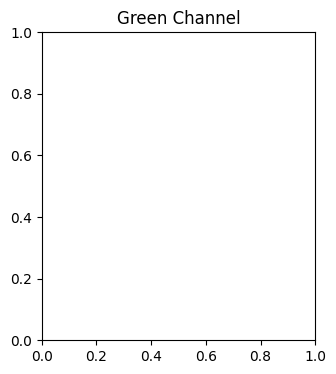

In [6]:
DATA_DIR = 'C:\\Users\\Sirius\\Desktop\\neuronetwork\\01_Train_Val_Oil_Spill_images' 
IMAGE_SUBDIR = 'Oil' # Поддиректория, где хранятся двухканальные изображения
MASK_SUBDIR = 'Mask oil'   # Поддиректория, где хранятся пиксельные маски

IMAGE_HEIGHT = 256 
IMAGE_WIDTH = 256  
NUM_CHANNELS = 2   
NUM_CLASSES = 1    


# --- 2. Загрузка и предварительная обработка данных ---


def load_image_and_mask(image_green_path, image_red_path, mask_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    """Загружает двухканальное изображение из отдельных каналов и маску"""
    try:
        # Загрузка каналов с помощью tifffile
        green_channel = tifffile.imread(image_green_path)
        red_channel = tifffile.imread(image_red_path)
        
        # Проверка размеров каналов
        if green_channel.shape != red_channel.shape:
            raise ValueError(f"Размеры каналов различаются: {image_green_path} {green_channel.shape} vs {image_red_path} {red_channel.shape}")
        
        # Объединение каналов
        image = np.stack([green_channel, red_channel], axis=-1)
        
        # Загрузка маски
        mask = tifffile.imread(mask_path)
        
        # Изменение размера
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Нормализация изображений
        image = image.astype(np.float32) / np.max(image)  # Масштабирование относительно максимума
        
        # Бинаризация и нормализация маски
        mask = (mask > 0).astype(np.float32)  # Бинаризация
        mask = np.expand_dims(mask, axis=-1)  # Добавление размерности канала
        
        return image, mask
    except Exception as e:
        print(f"Ошибка при обработке {image_green_path}: {e}")
        return None, None

def load_dataset(data_dir, image_subdir, mask_subdir):
    """Собирает пути к изображениям и маскам"""
    # Сбор всех файлов зеленого канала
    green_paths = sorted(
        [os.path.join(data_dir, image_subdir, f) 
         for f in os.listdir(os.path.join(data_dir, image_subdir)) 
         if f.endswith('_green.tif')]
    )
    
    # Создание путей к красному каналу и маскам
    image_paths = []
    mask_paths = []
    
    for green_path in green_paths:
        base_name = os.path.basename(green_path).replace('_green.tif', '')
        red_path = green_path.replace('_green.tif', '_red.tif')
        mask_path = os.path.join(data_dir, mask_subdir, f"{base_name}_mask.tif")
        
        if os.path.exists(red_path) and os.path.exists(mask_path):
            image_paths.append((green_path, red_path))
            mask_paths.append(mask_path)
    
    # Проверка соответствия количества
    if len(image_paths) != len(mask_paths):
        raise ValueError(f"Несоответствие изображений ({len(image_paths)}) и масок ({len(mask_paths)})")
    
    images = []
    masks = []
    
    for (green_path, red_path), mask_path in zip(image_paths, mask_paths):
        img, msk = load_image_and_mask(green_path, red_path, mask_path)
        if img is not None and msk is not None:
            images.append(img)
            masks.append(msk)
    
    # Визуализация примеров для проверки
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Green Channel")
    plt.imshow(images[0][:, :, 0], cmap='gray')
    plt.subplot(132)
    plt.title("Red Channel")
    plt.imshow(images[0][:, :, 1], cmap='gray')
    plt.subplot(133)
    plt.title("Mask")
    plt.imshow(masks[0].squeeze(), cmap='gray')
    plt.savefig("data_sample.png")
    plt.close()
    
    return np.array(images), np.array(masks)

# --- 3. Метрики и функции потерь ---
def dice_coef(y_true, y_pred, smooth=1e-6):
    """Коэффициент Dice для оценки сегментации"""
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), 'float32')
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), 'float32')
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Функция потерь на основе Dice"""
    return 1 - dice_coef(y_true, y_pred)
# --- 4. Архитектура U-Net с Transpose Convolution ---
def unet_model(input_size=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS), num_classes=NUM_CLASSES):
    inputs = keras.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)
    
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    
    # Decoder с Conv2DTranspose
    u5 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
    
    u6 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(c7)
    
    # Выходной слой
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(c7)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- 5. Загрузка данных ---
print("Загрузка данных...")
try:
    X, y = load_dataset(DATA_DIR, IMAGE_SUBDIR, MASK_SUBDIR)
    print(f"Загружено {len(X)} изображений и масок")
    print(f"Форма изображений: {X.shape}, Масок: {y.shape}")
    
    # Проверка нормализации
    print(f"Диапазон изображений: [{X.min()}, {X.max()}]")
    print(f"Уникальные значения маски: {np.unique(y)}")
    
    # Разделение данных
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Обучающая выборка: {X_train.shape}, Валидационная: {X_val.shape}")

except Exception as e:
    print(f"Ошибка загрузки: {e}")
    raise

# --- 6. Создание и обучение модели ---
model = unet_model()
model.summary()

# Компиляция с Dice Loss
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',  # Можно использовать dice_loss
    metrics=['accuracy', dice_coef]
)

# Колбэки
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

# Обучение
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

# --- 7. Оценка и сохранение ---
print("Оценка модели...")
model.load_weights('best_model.h5')  # Загрузка лучших весов
loss, acc, dice = model.evaluate(X_val, y_val, verbose=0)
print(f"Итоговые метрики | Loss: {loss:.4f}, Acc: {acc:.4f}, Dice: {dice:.4f}")

# Визуализация истории обучения
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Validation Dice')
plt.title('Dice Coefficient')
plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training_history.png')

# Сохранение модели
model.save('final_unet_model.h5')
print("Модель сохранена как 'final_unet_model.h5'")

# --- 8. Пример предсказания ---
sample = X_val[0:1]
pred = model.predict(sample)[0]

plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.title("Green Channel")
plt.imshow(sample[0, :, :, 0], cmap='gray')
plt.subplot(132)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='jet')
plt.subplot(133)
plt.title("Ground Truth")
plt.imshow(y_val[0].squeeze(), cmap='gray')
plt.savefig('prediction_sample.png')
plt.close()
